<a href="https://colab.research.google.com/github/salaheddinos/World_Happiness_Report_Project/blob/main/WHR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pingouin as pg
import chart_studio.plotly as py #For World Map
import plotly.express as px
import pycountry
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
# Install library for partial correlations
pip install pingouin

In [ ]:
# Install library for world map
pip install chart_studio

In [ ]:
# Intstall library for country codes
pip install pycountry==1.20

In [ ]:
# Import df
df = pd.read_excel('WHR.xls')  

In [ ]:
# Inspect df
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266


In [ ]:
# Shape of df
df.shape

(153, 20)

Our dataset contains 153 rows (Countries) and 20 columns (with 6 features for each country).

In [ ]:
# Function that finds potential missing values 
def missing(df):
  nulls = df.isnull().sum().sort_values()
  plt.figure(figsize=(5,5))
  sns.barplot(x=nulls.index, y=nulls.values)
  x= plt.xticks(rotation=90)

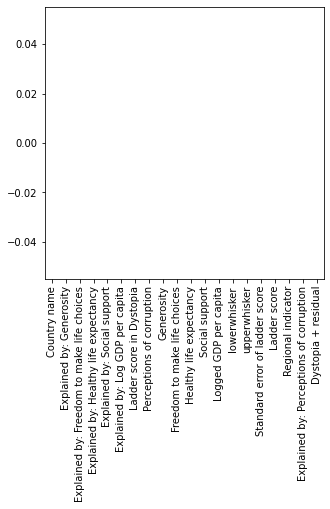

In [ ]:
# Missing values
missing(df)

No missing values.

#Exploratory Data Analysis (EDA) 

---



In [ ]:
# Drop, Rename and pick columns of interest 
data = df.copy()
data = data.drop(['Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Ladder score in Dystopia'], axis=1)
data = data.rename(columns={"Country name":"Country","Regional indicator":"Region","Ladder score":"Score"})

In [ ]:
# Describe data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Ladder score,153.0,5.473240,1.112270,2.566900,4.724100,5.515000,6.228500,7.808700
Logged GDP per capita,153.0,9.295706,1.201588,6.492642,8.350645,9.456313,10.265124,11.450681
Social support,153.0,0.808721,0.121453,0.319460,0.737217,0.829204,0.906747,0.974670
Healthy life expectancy,153.0,64.445529,7.057848,45.200001,58.961712,66.305145,69.289192,76.804581
Freedom to make life choices,153.0,0.783360,0.117786,0.396573,0.714839,0.799805,0.877709,0.974998
Generosity,153.0,-0.014568,0.151809,-0.300907,-0.127015,-0.033665,0.085429,0.560664
Perceptions of corruption,153.0,0.733120,0.175172,0.109784,0.683019,0.783122,0.849151,0.935585
Log GDP per capita,153.0,0.868771,0.372416,0.000000,0.575862,0.918549,1.169229,1.536676
Social support,153.0,1.155607,0.286866,0.000000,0.986718,1.203987,1.387139,1.547567
Healthy life expectancy,153.0,0.692869,0.254094,0.000000,0.495443,0.759818,0.867249,1.137814


We can see that the mean happiness score is 5.40 (1.11 sd). 

Text(0.5, 1.0, 'Mean Happiness Scores by Region')

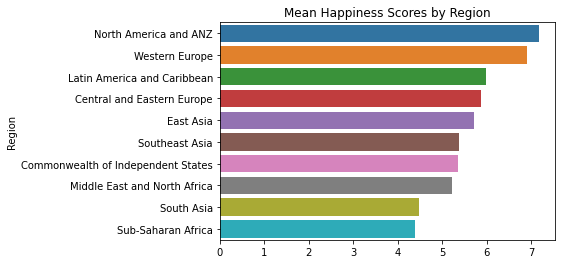

In [ ]:
# Let's see how regions compare in terms of Happiness Score
grouped_by_region = data.groupby("Region")['Score'].mean().sort_values(ascending=False)
# Plot results
ax = sns.barplot(x=grouped_by_region.values, y=grouped_by_region.index)
ax.set_title('Mean Happiness Scores by Region')

In [ ]:
# Top 20
top = data.drop('Score', axis=1)[:20]

Text(0.5, 1.0, 'TOP 20')

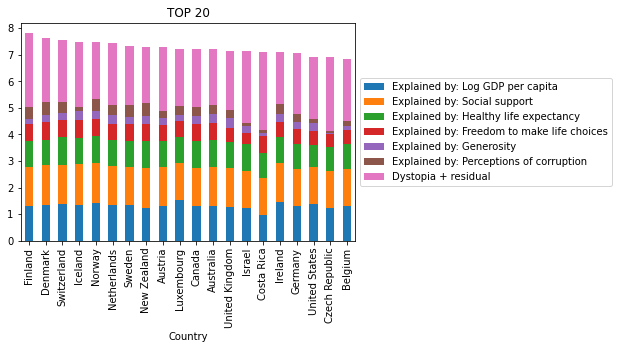

In [ ]:
# Happiness Score by country (Top 20)
top.set_index("Country").plot(kind='bar', stacked=True)
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.title('TOP 20')

Text(0.5, 1.0, 'Top 20 happiest countries')

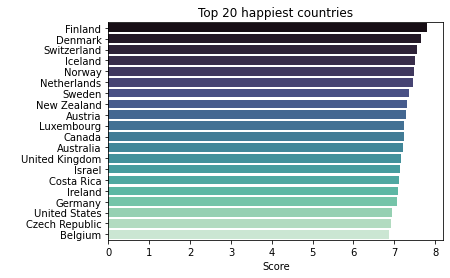

In [ ]:
# Rename cols
data.columns = data.columns.str.replace("Explained by:", "")
# Display Top 20 Happiest countries based on score
top = data[['Country', 'Score']].sort_values('Score', ascending=False)[:20]
sns.barplot(data=top, x='Score', y='Country', palette='mako')
x=plt.xticks(rotation=0)
y=plt.ylabel(" ")
plt.title('Top 20 happiest countries')


Text(0.5, 1.0, 'Top 20 least happiest countries')

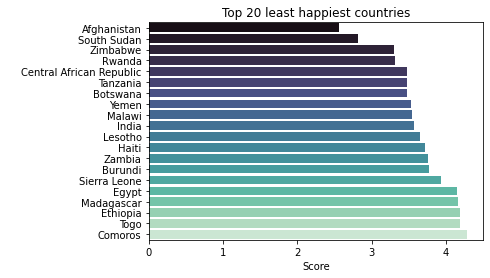

In [ ]:
# Display Top 20 Least Happiest countries based on score
down = data[['Country', 'Score']].sort_values('Score', ascending=True)[:20]
sns.barplot(data=down, x='Score', y='Country', palette='mako')
x=plt.xticks(rotation=0)
y=plt.ylabel(" ")
plt.title('Top 20 least happiest countries')

In [ ]:
# Display Top 20 countries for each feature
# Define a function that groups top 20 countries by their respective features and plot result
def rank_plot(frame, ascending=False):
  dfs_grouped = []
  for c in frame.columns[3:]:
    if frame[c].dtypes != 'object':
      grouped = pd.DataFrame(frame.groupby(['Country'])[c].mean().sort_values(ascending=ascending)[:20])
      dfs_grouped.append(grouped)
  
  for df in dfs_grouped:
    plt.figure()
    sns.barplot(data=df,x=df.iloc[:,0] , y=df.index, palette='mako')
    x=plt.title("Top 20 by country")
    x=plt.xticks(rotation=45)
    y=plt.ylabel(" ")

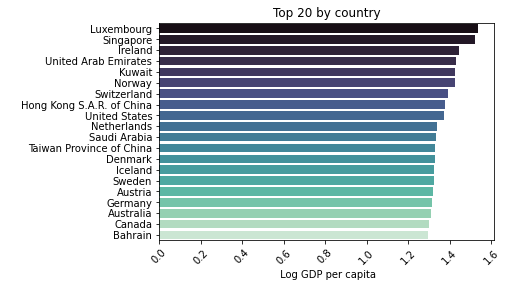

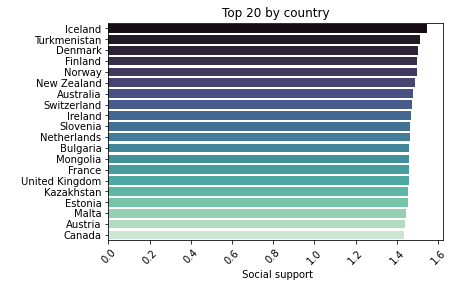

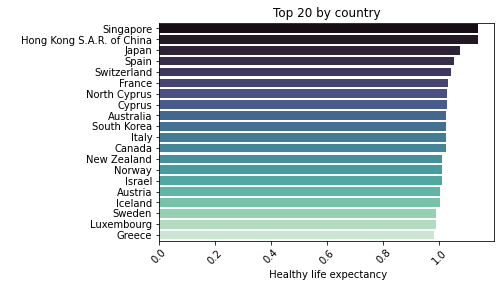

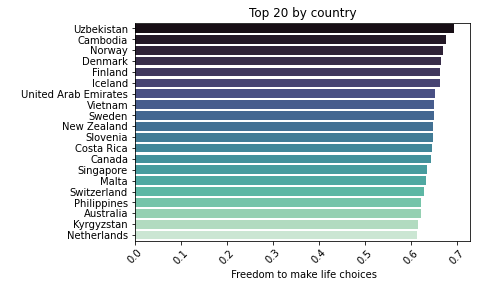

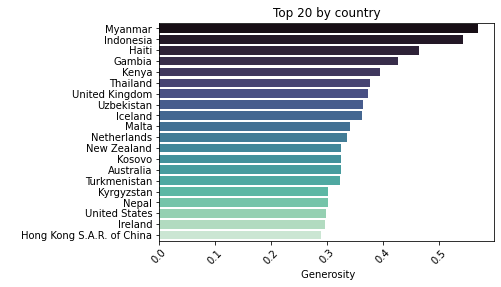

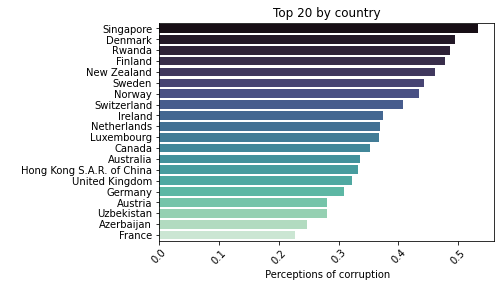

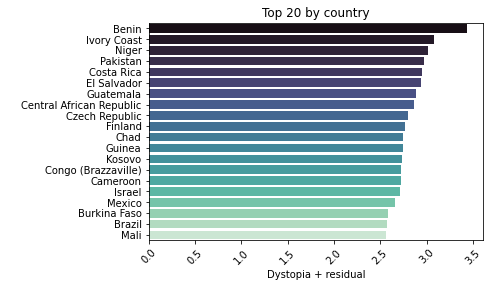

In [ ]:
# Top 20 highest scores in each feature
rank_plot(data)

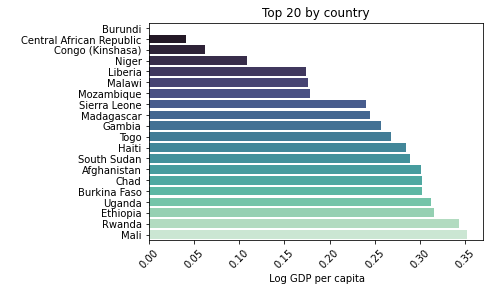

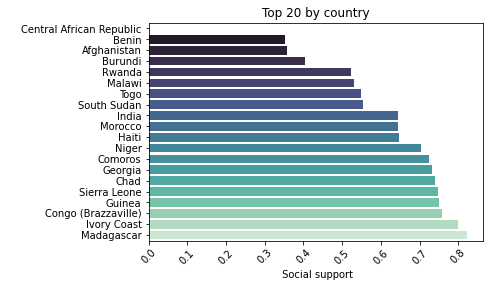

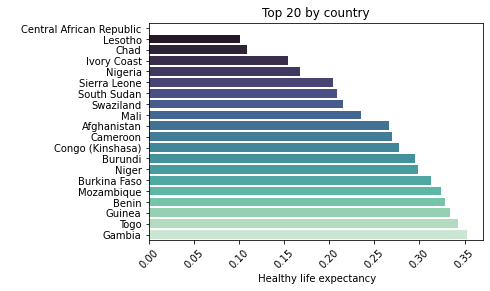

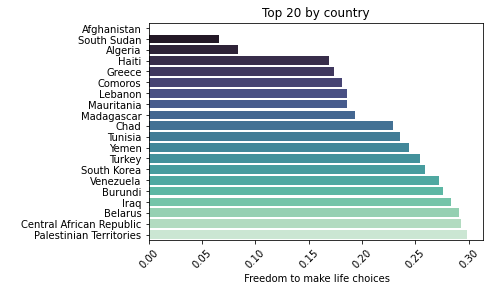

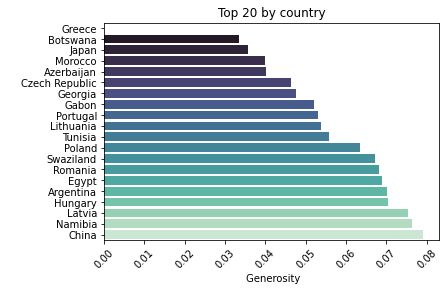

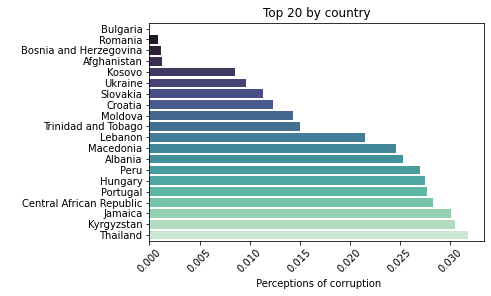

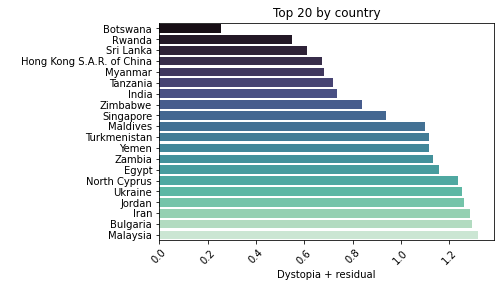

In [ ]:
# Top 20 least highest scores in each feature
rank_plot(data, ascending=True)

In [ ]:
# Display world map for happiness score
dataPlot = dict(type = 'choropleth', 
           locations = data['Country'],
           locationmode = 'country names',
           z = data['Score'], 
           text = data['Country'],
           colorbar = {'title':'Score'})
layout = dict(title = 'World Happiness Index', 
           geo = dict(showframe = False))
choromap3 = go.Figure(data = [dataPlot], layout=layout)
iplot(choromap3)  

## Correlations

In [ ]:
# Drop Dystopia + residual
data.drop("Dystopia + residual", axis=1, inplace=True)

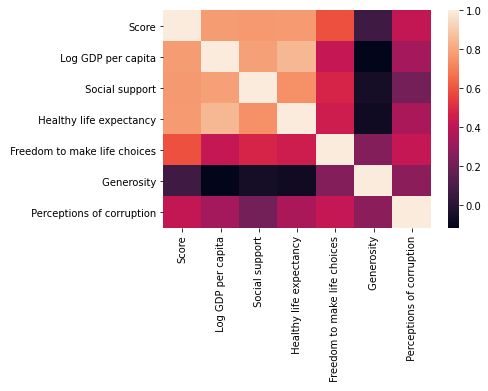

In [ ]:
# Let's study the correlations between the features of our dataset
corr = data.corr(method='pearson')
sns.heatmap(corr)

Without a surprise, we can see that happiness score is strongly positively correlated with healthy life expectancy, social support and GDP per capita. We suggests multicolinearity. 

In [ ]:
# Function that outputs a df describing correlations with target
def correlation_df(frame, method='pearson', target='Score'):
  cor_matrix_df = frame.corr(method=method)
  cor_df = pd.DataFrame(cor_matrix_df[target].sort_values(ascending=False)).drop([target], axis=0)
  
  cor_df['Pearson_corr'] = 0
  cor_df['R2'] = cor_df['Score'] ** 2
  
  def map_pearson(Pearson_corr):
    if 0.8 <= Pearson_corr <= 1:
      return "Very Strong Correlation"
    elif 0.6 <= Pearson_corr <= 0.799:
      return "Strong Correlation"
    elif 0.4 <= Pearson_corr <= 0.599:
      return "Medium Correlation"
    elif 0.1 <= Pearson_corr <= 0.399:
      return "Weak Correlation"
    elif 0 <= Pearson_corr < 0.1:
      return "Very Weak Correlation"
    elif Pearson_corr == 0:
      return "No Correlation"  
    else:
      return "Negative Correlation"
     
  cor_df['Pearson_corr'] = cor_df['Score'].apply(lambda score: map_pearson(score))
  return cor_df

In [ ]:
# Display corr df
correlation_df(data)

,Score,Pearson_corr,R2
Log GDP per capita,0.775374,Strong Correlation,0.601205
Healthy life expectancy,0.770316,Strong Correlation,0.593387
Social support,0.765001,Strong Correlation,0.585226
Freedom to make life choices,0.590597,Medium Correlation,0.348805
Perceptions of corruption,0.418305,Medium Correlation,0.174979
Generosity,0.069043,Very Weak Correlation,0.004767


GPD per capita, healthy life expectancy and social support are very strongly correlated with perceived life satisfaction. Freedom to make life choices and perceptions of corruptions seems less related to the happiness score with a medium correlation. Finally, generosity doesn't seem to be correlated with life satisfaction.



## Partial correlations

Partial correlation measures the strength of a relationship between two variables, while controlling for the effect of one or more other variables. For example, you might want to see if there is a correlation between amount of food eaten and blood pressure, while controlling for weight or amount of exercise.

For example, if we have economic data on the consumption, income, and wealth of various individuals and we wish to see if there is a relationship between consumption and income, failing to control for wealth when computing a correlation coefficient between consumption and income would give a misleading result, since income might be numerically related to wealth which in turn might be numerically related to consumption; a measured correlation between consumption and income might actually be contaminated by these other correlations. The use of a partial correlation avoids this problem.

In [ ]:
# Correlation between generosity and happiness score while controling for GPD per capita
pg.partial_corr(data=data, x=' Generosity', y='Score', 
                covar=[' Log GDP per capita'], method='pearson').round(3)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,153,0.257,"[0.1, 0.4]",0.066,0.053,0.001,16.143,0.897


Generosity is better associated with life satisfaction if we control for the effect of GDP per capita (.06 Prior Vs .257 with p value = .001). This might suggest that as GDP per capita increases the relationship between generosity and happiness becomes weaker.

In [ ]:
# Correlation between GDP per capita and happiness score while controling for social support
pg.partial_corr(data=data, x=' Log GDP per capita', y='Score', 
                covar=[' Social support'], method='pearson').round(3)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,153,0.441,"[0.3, 0.56]",0.195,0.184,0.0,1.053e+06,1.0


The relationship between GDP per capita and perceived happiness goes down from .77 to .44 if we control for the effect of social support. This is quite interesting because it could mean that as the satisfaction with friends and family, feeling loved, and feeling lonely which represent social support increases, the relationship between GDP per capita and life satisfaction becomes weaker. 

### Checking for Multicolinearity

In statistics, multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors.

In [ ]:
# # Checking for multicolinearity
def vif(X):
   # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

  return vif

In [ ]:
vif(data2.drop('Score', axis=1))

,variables,VIF
0,Log GDP per capita,28.134336
1,Social support,36.063724
2,Healthy life expectancy,33.139024
3,Freedom to make life choices,18.215495
4,Generosity,5.067042
5,Perceptions of corruption,3.327890


In regression analysis, most research papers consider a VIF (Variance Inflation Factor) > 10 as an indicator of multicollinearity, but some choose a more conservative threshold of 5 or even 2.5.

# Clustering

In order to cluster our data we'll use K-means clustering. 

K-means clustering is a popular unsupervised machine learning algorithm.

Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes.


In [ ]:
# Drop columns before clustering
data2 = data.copy()
data2.drop(["Country", "Region"], axis=1, inplace=True)
# Scale Data
scaler = StandardScaler()
data2 = scaler.fit_transform(data2)

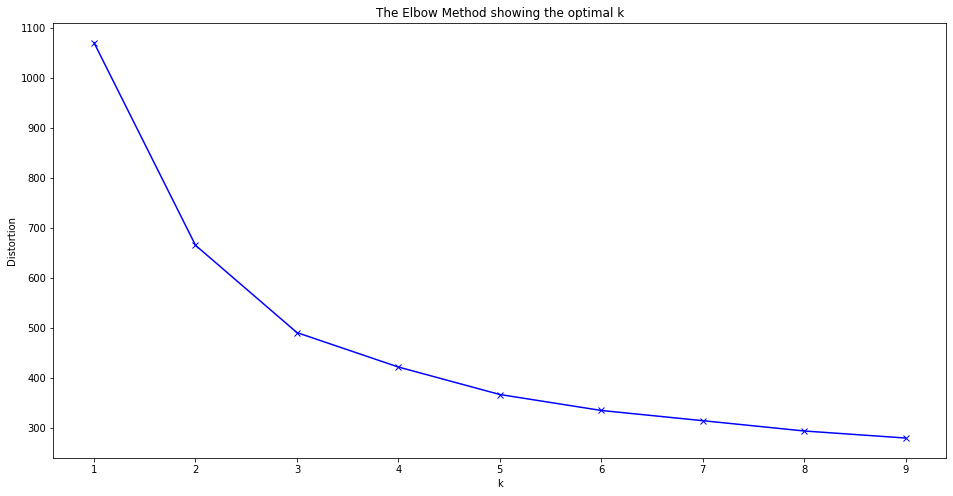

In [ ]:
# Training k-means model

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data2)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe by looking at the elbow plot, that the optimal number of clusters we should train our K-means algorithm on is between 2 and 3. We'll choose 3 since it has the least distorition value while keeping the number of components managable and easier to interpret.

In [ ]:
# Train the model on 3 clusters
kmean_model = KMeans(n_clusters=3, random_state=5)
kmean_y = kmean_model.fit_predict(data2)

In [ ]:
# Add labels to df
data['Cluster'] = kmean_model.labels_

In [ ]:
data.head()

,Country,Region,Score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Cluster
0,Finland,Western Europe,7.8087,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2
1,Denmark,Western Europe,7.6456,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2
2,Switzerland,Western Europe,7.5599,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2
3,Iceland,Western Europe,7.5045,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2
4,Norway,Western Europe,7.4880,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2


In [ ]:
# Seperate clusters into different dfs
df_c0 = data[data['Cluster'] == 0].drop("Cluster", axis=1)
df_c1 = data[data['Cluster'] == 1].drop("Cluster", axis=1) 
df_c2 = data[data['Cluster'] == 2].drop("Cluster", axis=1) 

## Visualize clusters

Text(0.5, 1.0, 'Clusters')

<Figure size 720x576 with 0 Axes>

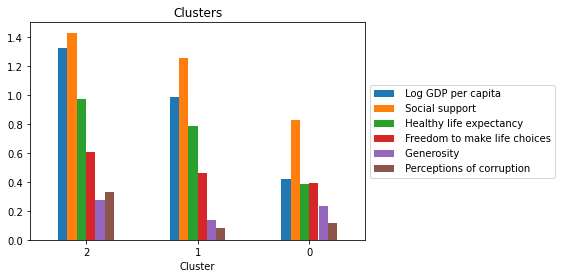

In [ ]:
# Display clusters in barchart
grouped = data.groupby('Cluster').mean().sort_values("Score", ascending=False)
plt.figure(figsize=(10,8))
grouped.iloc[:, 1:].plot(kind='bar', logy=False).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)
plt.title("Clusters")



**- Cluster 2 ("Very High Indicators"):**

Looking at this clustering chart, we can deduce that cluster 2 has the highest happiness score because it scores higher than all other clusters in all indicators, this cluster has higher GDP per capita than all the other clusters, which suggests that this cluster belongs mostly to the developped world. 

**- Cluster 1 ("Medium to High Inidcators"):**
This cluster scores less than cluster 2 in all indicators, it's mean GDP per capita is somehow average but also all other indicators. This suggests that this cluster belongs mostly to the developping world and thus has an average happiness score.

**- Cluster 0 ("Low Indicators"):**
This cluster scores lower than all other clusters except for generosity and perceptions of corruption. We can then conclude that Cluster 0 belong to the under developped world.

In [ ]:
# Label clusters
def cluster_name(cluster):
  if cluster == 2:
    return "High Indicators"
  elif cluster == 1:
    return "Medium Indicators"
  else:
    return "Low Indicators" 
data['Cluster_name'] = data['Cluster'].apply(lambda c: cluster_name(c))

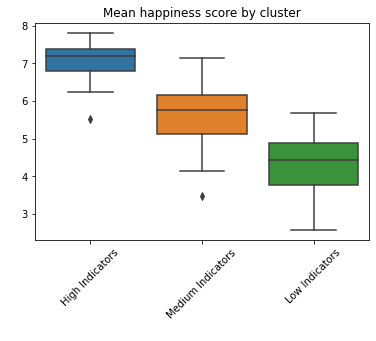

In [ ]:
# Scores by cluster
sns.boxplot(x="Cluster_name", y="Score", data=data)
plt.title('Mean happiness score by cluster')
plt.xticks(rotation=45)
plt.xlabel(" ")
plt.ylabel(" ")
plt.show()

We have two outliers : for cluster "high indicators" it's Australia and Albania for Cluster "Medium Indicators"

In [ ]:
# Display world map for clusters
dataPlot = dict(type = 'choropleth', 
           locations = data['Country'],
           locationmode = 'country names',
           z = data['Cluster'], 
           text = data['Country'],
           colorbar = {'title':'Cluster Group'})
layout = dict(title = 'Kmeans Clustering', 
           geo = dict(showframe = False))
choromap3 = go.Figure(data = [dataPlot], layout=layout)
iplot(choromap3)   

## Clusters' correlations

We can study the correlations again but this time for each cluster and see if there are some differences between them.

(0.0, 0.8)

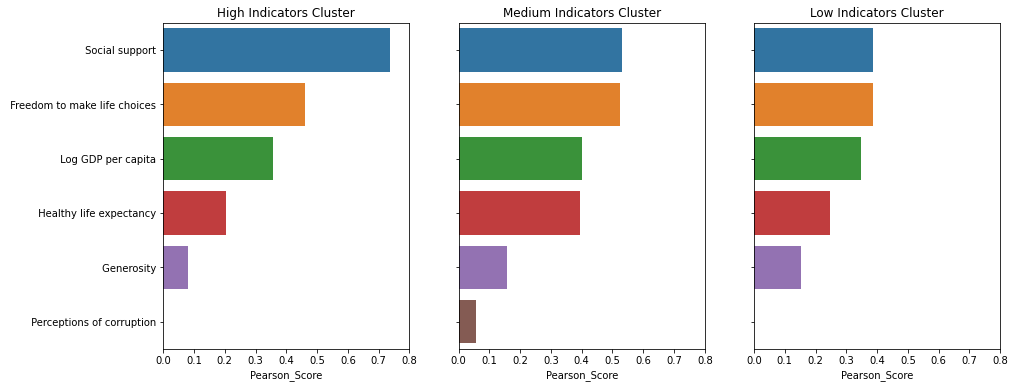

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k', sharey=True)
dfs = [df_c2, df_c1, df_c0]
dfs_corr = [correlation_df(df) for df in dfs]
for i in range(0, len(dfs_corr)):
  sns.barplot(x=dfs_corr[i]["Score"] , y=dfs_corr[i].index , data=dfs_corr[i], ax=axs[i])
axs[0].set_title("High Indicators Cluster")
axs[1].set_title("Medium Indicators Cluster")
axs[2].set_title("Low Indicators Cluster")
axs[0].set_xlabel("Pearson_Score")
axs[1].set_xlabel("Pearson_Score")
axs[2].set_xlabel("Pearson_Score")
axs[0].set_xlim([0, 0.8])
axs[1].set_xlim([0, 0.8])
axs[2].set_xlim([0, 0.8])

The one might think that GDP per capita would be the feature that is the strongest associated with life satisfaction but here we can see quite the opposite. Indeed, for clusters "High indicators" and "Medium Indicators", social support and freedom to make life choices are more strongly associated with happiness score than GDP. So even after controlling for a high GDP, having a strong social support and enjoying freedom will more likely be associated with a high perceived happiness.

We can confirm that by looking at the correlations in cluster "Low indicators", where the average GDP is lower than average but still social support and freedom to make life choices are also more strongly correlated with life satisfaction than GDP per capita.

Also generosity seem to be slighly more associated with life satisfaction in clusters medium and low indicators. This could maybe explain the result of the partial correlation we found when we controlled for the effect of GDP. 

# Building models to predict life satisfaction

In [ ]:
# Set X and y
X_cols = [c for c in data.columns if data[c].dtypes != "object"]
X = data[X_cols].drop(["Cluster", "Score"], axis=1)
y = data["Score"].values.reshape(-1,1)

### Multiple linear regression 

In [ ]:
# Load and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construct pipline  
pipe_lr = Pipeline([('scl', StandardScaler()),
			('reg', LinearRegression())])
# Construct cross-validation
cv_lr_scores = cross_val_score(pipe_lr, X_train, y_train, scoring='r2', cv=5)
# Mean score
print("Training score : {}".format(np.round(r2_score(y_train, pipe_lr.fit(X_train, y_train).predict(X_train)), 3)))
print("Test set score : {}".format(np.round(cv_lr_scaled_scores.mean(), 3)))

Training score : 0.765
Test set score : 0.742


Linear regression gives us a precision score on unseen data of about 74.2%. 

Text(0.5, 1.0, 'Feature importance')

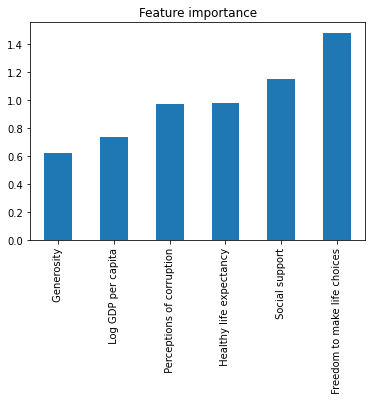

In [ ]:
# Feature importance 
# Get importance
reg_model = LinearRegression()
importance = reg_model.fit(X, y).coef_
# summarize feature importance
summary = pd.DataFrame(importance, columns=X.columns)
summary.T.sort_values(0).plot(kind="bar",legend=False)
plt.title("Feature importance")

The model didn't eliminate any feature since all of them have coefs > 0. social support and freedom to make life choices contributed most to the model.

## Ridge regression

In [ ]:
# Make pipline ridge regression
pipe_ridge = Pipeline([('scl', StandardScaler()),
			('regressor', Ridge())])

# creating a dictionary containing potential values of alpha
alpha_values = {'regressor__alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
              
# Set GridSearch to find best param
gr_ridge = GridSearchCV(estimator=pipe_ridge,
			param_grid=alpha_values,
			scoring='r2',
			cv=5)
gr_ridge.fit(X_train, y_train)
print("Training score : {}".format(np.round(r2_score(y_train, pipe_ridge.fit(X_train, y_train).predict(X_train)), 3)))
print('Test set score : ', np.round(gr_ridge.score(X_test, y_test), 2))
print('The best value of alpha is:',gr_ridge.best_params_)

Training score : 0.765
Test set score :  0.62
The best value of alpha is: {'regressor__alpha': 20}


## Random forest regressor 

In [ ]:
# Make pipeline for random forest
pipe_rf = Pipeline([('scl', StandardScaler()),
			('rf', RandomForestRegressor(random_state=42))])

# Set candidate hyperparameters
n_estimators = [500, 800, 1500, 2500, 5000]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40, 50, 60]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15]

# Set grid params
grid_params_rf = [{'rf__n_estimators': n_estimators,
		'rf__min_samples_leaf': min_samples_leaf,
		'rf__max_depth': max_depth,
		'rf__min_samples_split': min_samples_split,
    'rf__max_features': max_features}]

rf_random = RandomizedSearchCV(estimator=pipe_rf, 
                               param_distributions= grid_params_rf, n_iter = 5,
                               cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

rf_random.fit(X_train, y_train.ravel())
print("Training score : {}".format(np.round(r2_score(y_train, pipe_rf.fit(X_train, y_train.ravel()).predict(X_train)), 3)))
print('Test set score : ', np.round(rf_random.score(X_test, y_test),2))
print('The best params are:',rf_random.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   47.0s finished


Training score : 0.969
Test set score :  0.69
The best params are: {'rf__n_estimators': 2500, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 50}


# Conclusion

In [ ]:
# Get final linear regression model equation
import statsmodels.api as sm
from statsmodels.api import OLS
X = sm.add_constant(X)
OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     72.36
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           2.86e-41
Time:                        21:28:10   Log-Likelihood:                -127.33
No. Observations:                 153   AIC:                             268.7
Df Residuals:                     146   BIC:                             289.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.8872      0.227      8.307      0.000       1.438       2.336
 Log GDP per capita               0.7391      0.265      2.791      0.006       0.216       1.263
 Social support                   1.1530      0.280      4.119      0.000       0.600       1.706
 Healthy life expectancy          0.9807      0.360      2.721      0.007       0.268       1.693
 Freedom to make life choices     1.4825      0.415      3.571      0.000       0.662       2.303
 Generosity                       0.6208      0.510      1.218      0.225      -0.386       1.628
 Perceptions of corruption        0.9729      0.488      1.995      0.048       0.009       1.937
==============================================================================
Omnibus:                        7.971   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.701
Skew:                          -0.503   Prob(JB):                       0.0213
Kurtosis:                       3.441   Cond. No.                         24.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Linear regression model for life satisfaction

In order to have a strong predictive value, linear regression analysis should meet some statistical assumption. To keep this notebook short, I already checked all the assumptions and found out that all of them were met, thus our model will have a good predictive value. The model will be as follow: 

**Life satisfaction** = *1.48 * Freedom_to_make_life_choices + 1.15 * Social_support + 0.98 * Healthy_life_expectancy + 0.73 * Log_GDP_per_capita + 0.97 * Perceptions_of_corruption*

Note : Generosity has a non statistically significant p-value, thus it was eliminated from the model.

Life satisfaction is modeled best by using multiple linear regression. We acheived a precision score of R2 of 74.2 % on test set. Other models such as ridge and random forest couldn't acheive this score, although that random forest did very well on training score but couldn't generalize well on unseen data. We should keep in mind though that it's a small dataset and such algorithms are best suited for larger sample sizes. Still, this analyses helped us shed light on some factors that are most likely to be associated with perceived happiness. To summarize, life satisfaction seems to be more associated with indicators that are more subjective such as feeling of freedom and the support the one might receive from their families and the society. 